In [1]:
import GEOparse
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt

# GSE89632

This notebook provides a brief exploration of the [GSE89632 dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE89632). Our goal is to extract (1) gene expression intensity values, (2) the condition of each patient, and (3) a symbol for each gene in the dataset.

We start by loading the dataset with GEOparse and creating a cycling iterator to go through all GEO samples.

In [2]:
gse = GEOparse.get_GEO(geo="GSE89632", destdir='../data', silent=True)
gsm_cycler = itertools.cycle(gse.gsms.items())

Here, we visualize single GEO samples, each represented by a DataFrame containing probes as rows and a `VALUE` column with the gene expression intensity values.

In [3]:
gsm_name, gsm = next(gsm_cycler)
table = gsm.table
print(table['VALUE'].describe())
table.head()

count    29377.000000
mean        10.458177
std          1.988316
min          7.439051
25%          8.678906
50%         10.107389
75%         12.132462
max         15.758859
Name: VALUE, dtype: float64


,ID_REF,VALUE,Detection Pval
0,ILMN_1802380,12.358835,0.0000
1,ILMN_1792389,10.625872,0.0000
2,ILMN_3308818,9.074651,0.0069
3,ILMN_3242405,14.510260,0.0000
4,ILMN_2375156,10.159377,0.0000


Each GEO sample contains relevant metadata.

In [4]:
gsm_name, gsm = next(gsm_cycler)

for k, v in gsm.metadata.items():
    print(f'{k}: {v}')

title: ['liver_NASH_CL-87']
geo_accession: ['GSM2385721']
status: ['Public on Nov 08 2016']
submission_date: ['Nov 07 2016']
last_update_date: ['Nov 08 2016']
type: ['RNA']
channel_count: ['1']
source_name_ch1: ['liver']
organism_ch1: ['Homo sapiens']
taxid_ch1: ['9606']
characteristics_ch1: ['array ^sample: 8473515021_E', 'diagnosis: NASH', 'steatosis (%): 90', 'fibrosis (stage): 4', 'lobular inflammation (severity): 1', 'ballooning (intensity): 1', 'nafld activity score: 5', 'age (y): 52', 'gender: female', 'aspartate transaminase (u/l): 83', 'alanine transaminase (u/l): 24', 'alkaline phosphatase (u/l): 188', 'triglycerides (mmol/l): 0.99', 'total cholesterol (mmol/l): 2.61', 'ldl cholesterol (mmol/l): 1.48', 'hdl cholesterol (mmol/l): 0.68', 'fasting glucose (mmol/l): 5', 'hemoglobin a1c: 0.053', 'diabetes: no']
molecule_ch1: ['total RNA']
extract_protocol_ch1: ["Total RNA was extracted from liver biopsies using the mirVana miRNA Isolation kit (Life Technologies Corp., Carlsbad, CA

We are interested in knowing the condition of each patient; hence, we extract it from the `characteristics_ch1` value. The dataset contains 24 control patients, 20 patients with steatosis and 19 patients with NASH. For integration with other datasets, we map these names to _control_, _NAFL_ and _NASH_.

In [5]:
geo_accessions = [gsm.metadata['geo_accession'][0] for _, gsm in gse.gsms.items()]
stages = [next((item.split(": ")[1] for item in gsm.metadata['characteristics_ch1'] if item.startswith("diagnosis:")), None) for _, gsm in gse.gsms.items()]
print('Original conditions: ', np.unique(stages))
mapping = {'HC': 'control', 'SS': 'NAFL', 'NASH': 'NASH'}
stages = [mapping[stage] for stage in stages]
values, counts = np.unique(stages, return_counts=True)

print('Conditions:')
for stage, count in zip(values, counts):
    print(f'- {stage}: {count}')

Original conditions:  ['HC' 'NASH' 'SS']
Conditions:
- NAFL: 20
- NASH: 19
- control: 24


Now we gather all samples in a single DataFrame.

In [6]:
data = []
for i, (gsm_name, gsm) in enumerate(gse.gsms.items()):
    table = gsm.table[['ID_REF', 'VALUE']]
    table.columns = ['ID_REF', gsm_name]
    data.append(table if i == 0 else table[gsm_name])
data = pd.concat(data, axis=1)
data.set_index('ID_REF', inplace=True)

data.head()

,GSM2385720,GSM2385721,GSM2385722,GSM2385723,GSM2385724,GSM2385725,GSM2385726,GSM2385727,GSM2385728,GSM2385729,...,GSM2385773,GSM2385774,GSM2385775,GSM2385776,GSM2385777,GSM2385778,GSM2385779,GSM2385780,GSM2385781,GSM2385782
ID_REF,,,,,,,,,,,,,,,,,,,,,
ILMN_1802380,12.358835,12.606474,12.393665,13.137311,12.472414,12.769886,11.666555,12.934494,12.565463,12.089334,...,12.335036,12.626303,11.814068,12.533229,13.195674,11.035422,12.209003,12.246716,12.264044,12.973392
ILMN_1792389,10.625872,11.075024,11.091969,11.949015,11.537207,12.150476,11.005180,12.986650,10.704872,11.248106,...,11.899030,11.652986,11.318297,11.730129,12.082602,11.787084,10.795445,10.119894,11.394989,12.261615
ILMN_3308818,9.074651,9.429843,9.401119,9.156379,9.576745,9.648910,9.151682,10.505579,8.827234,8.892095,...,9.301877,9.743835,9.761029,9.440359,9.542881,9.655934,9.664660,9.377096,9.704641,9.582920
ILMN_3242405,14.510260,14.743216,14.703407,14.721431,14.632786,14.774042,14.767287,13.991133,14.285110,14.577412,...,14.128666,14.041429,14.129390,14.023711,14.014086,13.946819,14.015102,13.949124,13.589004,13.390902
ILMN_2375156,10.159377,10.141242,10.442173,10.730599,10.762320,10.302935,10.710007,10.726230,10.358349,10.442871,...,9.734538,10.080256,9.353672,10.099712,10.600777,9.022009,10.327999,10.010979,9.963366,10.620427


Let's plot the distribution of intensities. It seems there was some normalization done on this data. Gene expression values per sample seem to have the same scale.

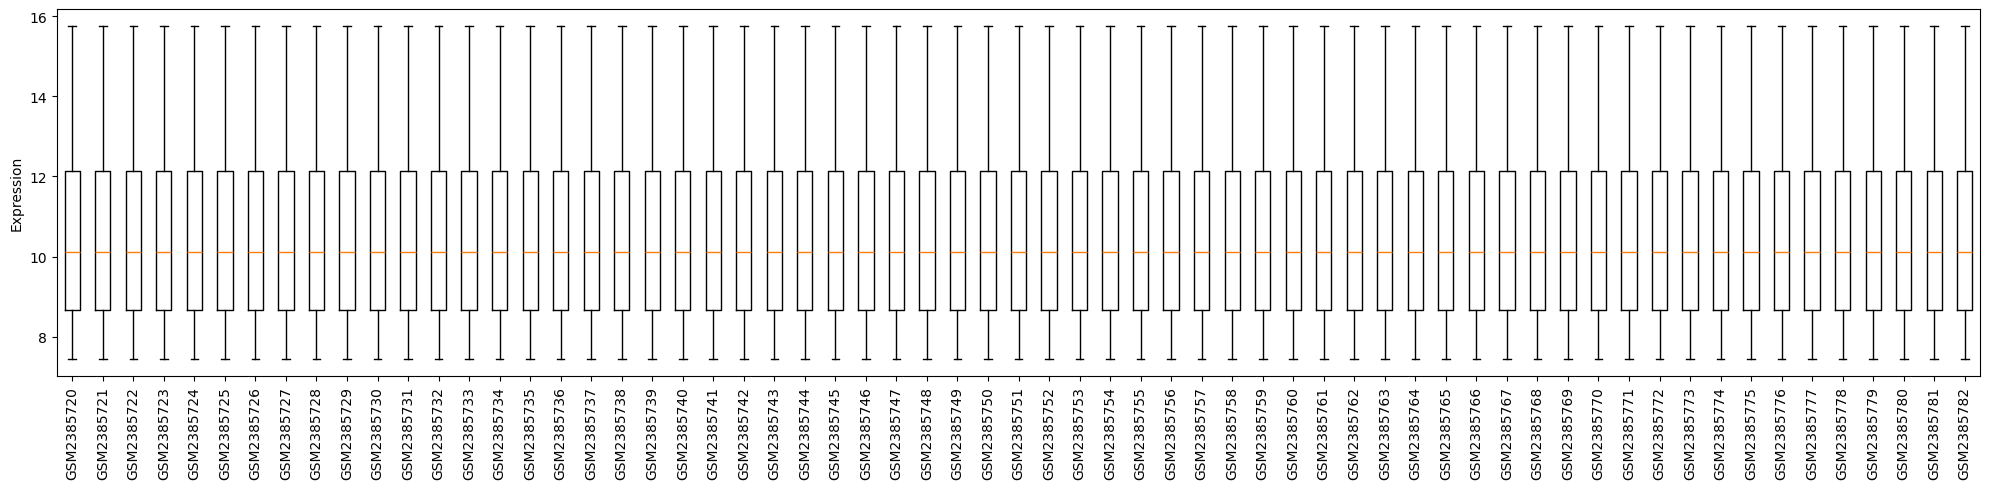

In [7]:
values = data.values.astype(float)

plt.figure(figsize=(20, 5))
plt.boxplot(values, tick_labels=data.columns, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Expression')
plt.tight_layout()
plt.show()

Finally, we look at the platform data to search for gene symbols. Our GSE object (naturally) has one single platform.

In [8]:
gse.gpls.items()

dict_items([('GPL14951', <d: GPL14951>)])

The platform metadata contains relevant information, like the microarray's name, GEO accession ID, and number of probes. The table data contains information about each probe.

In [9]:
gpl = list(gse.gpls.values())[0]

print('Title: ', gpl.metadata['title'][0])
print('GEO Accession: ', gpl.metadata['geo_accession'][0])
print('Number of probes: ', gpl.metadata['data_row_count'][0])

gpl_table = gpl.table
gpl_table.head(3)

Title:  Illumina HumanHT-12 WG-DASL V4.0 R2 expression beadchip
GEO Accession:  GPL14951
Number of probes:  29377


,ID,Transcript,Species,Source,Search_Key,ILMN_Gene,Source_Reference_ID,RefSeq_ID,Entrez_Gene_ID,GI,...,Probe_Chr_Orientation,Probe_Coordinates,Cytoband,Definition,Ontology_Component,Ontology_Process,Ontology_Function,Synonyms,Obsolete_Probe_Id,GB_ACC
0,ILMN_3166687,ILMN_333737,ILMN Controls,ILMN_Controls,ERCC-00162,ERCC-00162,ERCC-00162,NaN,NaN,NaN,...,NaN,NaN,NaN,Methanocaldococcus jannaschii spike-in control...,NaN,NaN,NaN,NaN,NaN,DQ516750
1,ILMN_3165566,ILMN_333646,ILMN Controls,ILMN_Controls,ERCC-00071,ERCC-00071,ERCC-00071,NaN,NaN,NaN,...,NaN,NaN,NaN,Synthetic construct clone NISTag13 external RN...,NaN,NaN,NaN,NaN,NaN,DQ883654
2,ILMN_3164811,ILMN_333584,ILMN Controls,ILMN_Controls,ERCC-00009,ERCC-00009,ERCC-00009,NaN,NaN,NaN,...,NaN,NaN,NaN,Synthetic construct clone TagJ microarray control,NaN,NaN,NaN,NaN,NaN,DQ668364


Here, we are interested in gene symbols. We retain 29,377 probes with 20,819 genes.

In [10]:
symbols = gpl_table['Symbol'].dropna()
print(f'Number of clean probes: {len(symbols)}')
print(f'Number of unique genes: {len(symbols.unique())}')
print(f'Example genes: {symbols.sample(5).values}')

Number of clean probes: 29377
Number of unique genes: 20819
Example genes: ['ATG9A' 'MIR371' 'IARS2' 'KIAA0495' 'MIR203']
